In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets,transforms
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size =128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:03<00:00, 45896940.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
print("Classes",trainset.classes)

Classes ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Label:frog


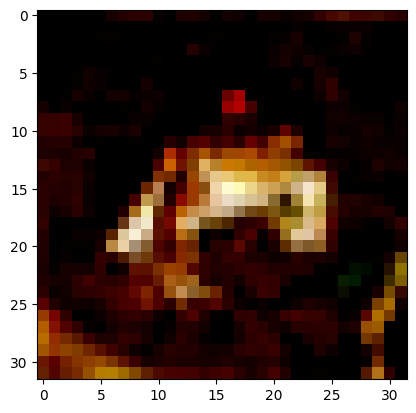

In [4]:
def display_img(img,label):
  print(f"Label:{trainset.classes[label]}")
  plt.imshow(img.permute(1,2,0))

display_img(*trainset[0])

In [5]:
img,label=trainset[0]
print(img.shape,label)

torch.Size([3, 32, 32]) 6


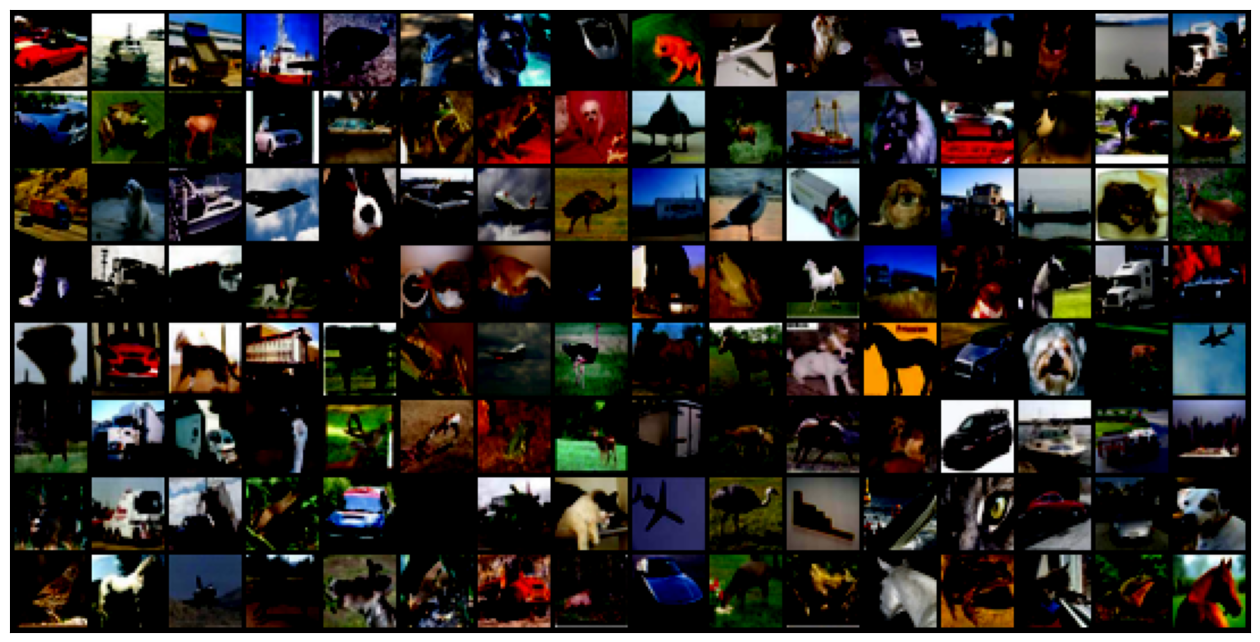

In [6]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
  for images,labels in dl:
    fig,ax=plt.subplots(figsize=(16,12))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break
show_batch(trainloader)


In [14]:
import torch.nn as nn

class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.log_softmax(x)
        return x


In [15]:
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 20

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
model = ConvNeuralNet(num_classes)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.Adam(model.parameters())

total_step = len(trainloader)

In [17]:
for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(trainloader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))




Epoch [1/20], Loss: 1.3074
Epoch [2/20], Loss: 0.8845
Epoch [3/20], Loss: 0.7171
Epoch [4/20], Loss: 0.5653
Epoch [5/20], Loss: 0.5261
Epoch [6/20], Loss: 0.4517
Epoch [7/20], Loss: 0.4901
Epoch [8/20], Loss: 0.2902
Epoch [9/20], Loss: 0.2089
Epoch [10/20], Loss: 0.1181
Epoch [11/20], Loss: 0.0974
Epoch [12/20], Loss: 0.1350
Epoch [13/20], Loss: 0.1365
Epoch [14/20], Loss: 0.1034
Epoch [15/20], Loss: 0.0871
Epoch [16/20], Loss: 0.0745
Epoch [17/20], Loss: 0.0912
Epoch [18/20], Loss: 0.0072
Epoch [19/20], Loss: 0.1303
Epoch [20/20], Loss: 0.0130


In [18]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels = predicted.cpu().numpy()
        true_labels = labels.cpu().numpy()
        f1=f1_score(predicted_labels,true_labels,average="micro")
        confusion=confusion_matrix(true_labels,predicted_labels)


    print('Accuracy of the network on the {} train images: {} %'.format(50000, 100 * correct / total))
    print("F1_score",f1)
    print("Confusion_Matrix_training",confusion)
    correct=0
    total=0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels = predicted.cpu().numpy()
        true_labels = labels.cpu().numpy()
        f1=f1_score(predicted_labels,true_labels,average="micro")
        confusion=confusion_matrix(true_labels,predicted_labels)

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))
    print("F1_score",f1)
    print("Confusion_Matrix_test_data",confusion)



Accuracy of the network on the 50000 train images: 98.76 %
F1_score 0.9875
Confusion_Matrix_training [[ 4  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0]
 [ 1  0 13  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0  8]]
Accuracy of the network on the 10000 test images: 75.26 %
F1_score 0.875
Confusion_Matrix_test_data [[2 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 1 0 2 0 0]
 [0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 3]]


Computation time: 0.0001 seconds
